## **Predicting Body Mass Index**

Aim:    PANDAS, NUMPY, sqlalchemy,pyodbc, PANDAS_PROFILING, SEABORN, MATPLOTLIB, SKLEARN, XGBOOST, KAGGLE

ensure font is the same on dashboard and presentation 
make dashboard legends square??? 

In [69]:
# Importing project dependencies 

# General 
import pandas as pd 
import numpy as np

# Data warehousing 
from sqlalchemy import create_engine
import pyodbc
import urllib

# Exploratory Data Analysis & Visualisation 
%matplotlib inline
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering and Modelling 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

# Model imporvement 
from sklearn.metrics import accuracy_score,  classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import metrics
import math

# Model export for deployment 
import pickle

#### **----------------------------------  1. Data collection  -----------------------------------**

In [2]:
# Importing data through API 
!kaggle datasets download -d yasserh/bmidataset -p ..\Data --unzip 


  0%|          | 0.00/2.19k [00:00<?, ?B/s]
100%|██████████| 2.19k/2.19k [00:00<00:00, 566kB/s]


In [3]:
# Reading data into dataframe 
data = pd.read_csv('../Data/bmi.csv')

#### **----------------------------------  2. Data pre-processing  -----------------------------------**

In [4]:
# Viewing first 5 rows of data
data.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


Formula: weight (kg) / [height (m)]2

In [5]:
%%capture 
# Supressing cell run output 

"""
BMI	Condition 
# Below 18.5   == Underweight        ----  INDEX == 0
# 18.5-24.9    == Normal weight      ----  INDEX == 1
# 25-29.9	   == Overweight         ----  INDEX == 2
# 30-39.9      == Obese              ----  INDEX == 3 
# 40 and more  == Severely Obese     ----  INDEX == 4
"""

In [6]:
# Correcting BMI Indexes (Divided by 100 as height came orignally in cm)
data['newIndex'] = data['Weight'] / (data['Height']/100)**2

In [7]:
# Viewing first 5 rows of data
data.head()

,Gender,Height,Weight,Index,newIndex
0,Male,174,96,4,31.708284
1,Male,189,87,2,24.355421
2,Female,185,110,4,32.140248
3,Female,195,104,3,27.350427
4,Male,149,61,3,27.476240


In [8]:
# BMI conditions to correct the data index to UK(NHS) classifications
def set_bmi(row):
    if row["newIndex"] < 18.5:
        return 0
    elif row["newIndex"] >= 18.5 and  row["newIndex"] <= 24.999 :
        return 1
    elif row["newIndex"] >= 25 and  row["newIndex"] <= 29.999 :
        return 2
    elif row["newIndex"] >= 30 and  row["newIndex"] <= 39.999 :
        return 3
    else:
        return 4

# Using assign to add new column BMI based on the function conditions
data = data.assign(BMI=data.apply(set_bmi, axis=1))

pd.options.mode.chained_assignment = None  # Supressing SettingWithCopyWarning message

# Creating 'bmiclass' field 
data['bmiclass'] = ''

# Ouputing labelled column based on bmi of individual
data.bmiclass[data['BMI'] == 0] = 'Underweight'
data.bmiclass[data['BMI'] == 1] = 'Normal weight'
data.bmiclass[data['BMI'] == 2] = 'Overweight'
data.bmiclass[data['BMI'] == 3] = 'Obese'
data.bmiclass[data['BMI'] == 4] = 'Severely obese'

# Saving cleaned data as csv for visualisation
data.to_csv('../Data/bmi_clean.csv', index=False)

# Dropping unnecessary columns
data.drop(['Index','newIndex'], axis=1, inplace=True)

In [9]:
# Viewing first 5 rows of data
data.head()

,Gender,Height,Weight,BMI,bmiclass
0,Male,174,96,3,Obese
1,Male,189,87,1,Normal weight
2,Female,185,110,3,Obese
3,Female,195,104,2,Overweight
4,Male,149,61,2,Overweight


In [10]:
# Viewing the data types of the columns
data.dtypes

Gender      object
Height       int64
Weight       int64
BMI          int64
bmiclass    object
dtype: object

In [11]:
# Viewing dataset shape
data.shape

(500, 5)

In [12]:
# 1st check for null values and datatype check 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Gender    500 non-null    object
 1   Height    500 non-null    int64 
 2   Weight    500 non-null    int64 
 3   BMI       500 non-null    int64 
 4   bmiclass  500 non-null    object
dtypes: int64(3), object(2)
memory usage: 19.7+ KB


In [13]:
# 2nd check for null values
data.isnull().sum()

Gender      0
Height      0
Weight      0
BMI         0
bmiclass    0
dtype: int64

In [14]:
# Unique count for each variable
data.nunique()

Gender        2
Height       60
Weight      110
BMI           5
bmiclass      5
dtype: int64

In [15]:
# Viewing summary of statistics for numeric columns
data.describe()

,Height,Weight,BMI
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,2.806000
std,16.375261,32.382607,1.280486
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,2.000000
50%,170.500000,106.000000,3.000000
75%,184.000000,136.000000,4.000000
max,199.000000,160.000000,4.000000


In [16]:
# (SQL standard) Formatting column headers by removing potential capital letters and spaces in column headers 
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(' ','_')

#### **----------------------------------  3. Data Warehousing  -----------------------------------**

In [17]:
# Saving cleaned data as csv
data.to_csv('../Data/bmi_cleanML.csv', index=False)

In [18]:
# def ETL_SQLServer(Server,db,tablename):
#   """
#     :param Server: Destination Server
#     :param db: Destination Database name MUST ALREADY EXIST
#     :param tablename: Project ID and Dataset name
#     """

#   # SQL table header format
#   tablename = tablename.lower()
#   tablename = tablename.replace(' ','_')

#   quoted = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=%s;DATABASE=%s"%(Server,db))
#   engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

#   data.to_sql('{tb}'.format(tb=tablename), schema='dbo', con = engine, index=False, if_exists='replace')

#   return("ETL successful, {num} rows loaded into table: {tb}.".format(num=len(data.iloc[:,0]), tb=tablename))

In [19]:
# # Function to warehouse dataframe
# ETL_SQLServer("[SERVER NAME]","Projects","P11 bmi")

#### **----------------------------------  4. Exploratory data analysis  -----------------------------------**

In [20]:
# Checking distribution of categorical fields 
print(data.gender.value_counts())
print(data.bmi.value_counts())

Female    255
Male      245
Name: gender, dtype: int64
4    203
3    130
2     68
1     65
0     34
Name: bmi, dtype: int64


In [21]:
# Viewing summary of statistics for numeric columns
data.describe()

,height,weight,bmi
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,2.806000
std,16.375261,32.382607,1.280486
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,2.000000
50%,170.500000,106.000000,3.000000
75%,184.000000,136.000000,4.000000
max,199.000000,160.000000,4.000000


In [22]:
# Displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). 
chart = data.boxplot(column = ['height', 'weight'])
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0)
plt.title('The Factor of Body Mass Index', fontsize = 15, color = 'maroon', pad = 12)
plt.xlabel('Factors')
plt.ylabel('Count')
plt.show()

C:\Users\matti\AppData\Local\Temp/ipykernel_9132/495980808.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [23]:
%%capture 
# Supressing cell run output 

"""
# Viewing data distribution of 'height' column
sns.boxplot(x='height', data=data, color='yellow')

# Removing the spines from the right and upper portion of the plot by default.
sns.despine()
"""

In [24]:
%%capture 
# Supressing cell run output 

"""
# Viewing data distribution of 'weight' column
sns.boxplot(x='weight', data=data, color='green')

# Removing the spines from the right and upper portion of the plot by default.
sns.despine()
"""

In [25]:
# PairPlot to show relationships in a dataset. *(To view list of palettes enter random value, all palettes will be shown in error message)
plot = sns.pairplot(data, vars=['height', 'weight'], 
             hue="bmi", palette='RdYlGn', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)

# Setting plot title 
plt.suptitle('Pair Plot of Height and Weight Correlation to BMI', 
             size = 20, y=1.04);

# Removing the spines from the right and upper portion of the plot by default.
sns.despine()

In [26]:
pd.options.mode.chained_assignment = None  # Supressing SettingWithCopyWarning message

# Creating 'bmiclass' field 
data['bmiclass'] = ''

# Ouputing labelled column based on bmi of individual
data.bmiclass[data['bmi'] == 0] = 'Underweight'
data.bmiclass[data['bmi'] == 1] = 'Normal weight'
data.bmiclass[data['bmi'] == 2] = 'Overweight'
data.bmiclass[data['bmi'] == 3] = 'Obese'
data.bmiclass[data['bmi'] == 4] = 'Severely obese'

In [27]:
# Saving cleaned data as csv
data.to_csv('../Data/bmi_clean.csv', index=False)

In [28]:
# Calculations for bar chart 
Underweight = data[data['bmiclass'] == 'Underweight']['bmi'].count() / data.shape[0] * 100
Normalweight = data[data['bmiclass'] == 'Normal weight']['bmi'].count() / data.shape[0] * 100
Overweight = data[data['bmiclass'] == 'Overweight']['bmi'].count() / data.shape[0] * 100
Obese = data[data['bmiclass'] == 'Obese']['bmi'].count() / data.shape[0] * 100
Severelyobese = data[data['bmiclass'] == 'Severely obese']['bmi'].count() / data.shape[0] * 100


In [29]:
# Showing distribtuon of target values 
fig, ax = plt.subplots()
sns.countplot(x='bmi', palette="Set3", data=data)
bmiclasses = ['Underweight','Healthy','Overweight', 'Obese','Severely obese']
plt.xticks([0, 1, 2, 3, 4], bmiclasses)
plt.xlabel('BMI', size=15, labelpad=12, color='grey')
plt.ylabel('Count', size=15, labelpad=12, color='grey')
plt.title("Distribution of BMI in dataset", size=15, pad=20)
plt.ylim(0, 250)
plt.text(-0.2, 10, f"{round(Underweight, 2)}%", fontsize=12)
plt.text(0.75, 10, f"{round(Normalweight, 2)}%", fontsize=12)
plt.text(1.75, 10, f"{round(Overweight, 2)}%", fontsize=12)
plt.text(2.75, 10, f"{round(Obese, 2)}%", fontsize=12)
plt.text(3.75, 10, f"{round(Severelyobese, 2)}%", fontsize=12)
sns.despine()
plt.show()

C:\Users\matti\AppData\Local\Temp/ipykernel_9132/2039109783.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [30]:
# Calculations for bar chart 
Male = data[data['gender'] == 'Male']['bmi'].count() / data.shape[0] * 100
Female = data[data['gender'] == 'Female']['bmi'].count() / data.shape[0] * 100

In [31]:
# Showing distribtuon of target values 
fig, ax = plt.subplots()
sns.countplot(x='gender',hue="bmi", palette="Set3", data=data)
gender = ['Male','Female']
plt.xticks([0, 1], gender)
plt.xlabel('BMI', size=15, labelpad=12, color='grey')
plt.ylabel('Count', size=15, labelpad=12, color='grey')
plt.title("Distribution of BMI by gender", size=15, pad=20)
plt.ylim(0, 250)
plt.text(-0.2, 150, f"{round(Male, 2)}%", fontsize=12)
plt.text(0.75, 150, f"{round(Female, 2)}%", fontsize=12)
sns.despine()
plt.show()

C:\Users\matti\AppData\Local\Temp/ipykernel_9132/351321948.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [32]:
#correlation of each variable
data.corr()

,height,weight,bmi
height,1.000000,0.000446,-0.416359
weight,0.000446,1.000000,0.812227
bmi,-0.416359,0.812227,1.000000


In [33]:
# Viewing correlations of each features in dataset 
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,8))

# Plotting heat map
plot = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [34]:
# PANDAS PROFILING

# profile report of each variable
# pandas_profiling.ProfileReport(data)

# We only use the first 100 data points
# prof = pandas_profiling.ProfileReport(data.sample(n=100)) 
# prof.to_file(output_file='output.html')

#### **----------------------------------  5. Feature Engineering  -----------------------------------**

In [35]:
# Dropping fields that wont benefit the model
data.drop(['bmiclass'], axis=1,inplace=True)

In [36]:
# Viewing first 5 rows of data 
data.head()

,gender,height,weight,bmi
0,Male,174,96,3
1,Male,189,87,1
2,Female,185,110,3
3,Female,195,104,2
4,Male,149,61,2


In [37]:
# One hot encoding for encoding categorical variables
final_data = pd.get_dummies(data, drop_first=True)

In [38]:
# Viewing final dataset for model 
final_data

,height,weight,bmi,gender_Male
0,174,96,3,1
1,189,87,1,1
2,185,110,3,0
3,195,104,2,0
4,149,61,2,1
...,...,...,...,...
495,150,153,4,0
496,184,121,3,0
497,141,136,4,0
498,150,95,4,1


In [39]:
# Splitting dependent and independent features
X = final_data.drop('bmi', axis = 1)
y = final_data['bmi']

In [40]:
# Using train test split to split train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

# Viewing shape of train / test data
print(X_train.shape)
print(X_test.shape)

(400, 3)
(100, 3)


#### **----------------------------------  6. Modelling  -----------------------------------**

In [41]:
# Preparing algorithms in a list
random_state = 23
classifiers = [
    KNeighborsClassifier(n_neighbors = 5),
    LinearSVC(),
    DecisionTreeClassifier(criterion = 'gini', max_depth = 3),
    RandomForestClassifier(max_features = 'sqrt', n_jobs = 1, verbose = 1),
    XGBClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [42]:
pd.options.mode.chained_assignment = None  # Supressing SettingWithCopyWarning

# Creating a df to show models and their accuracy 
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns = log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    print("=" * 30)
    print(name)
    print('****  Results  ****')
    
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    print("\n")
    
    # Creating new df and appending results onto initial df 
    log_entry = pd.DataFrame([[name, acc * 100]], columns = log_cols)
    log = log.append(log_entry)
    
print("=" * 30)

KNeighborsClassifier
****  Results  ****
Accuracy: 93.0000%


LinearSVC
****  Results  ****
Accuracy: 46.0000%


DecisionTreeClassifier
****  Results  ****
Accuracy: 69.0000%


RandomForestClassifier
****  Results  ****
Accuracy: 91.0000%


[22:35:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matti\anaconda3\envs\P11\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\matti\anaconda3\envs\P11\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier
****  Results  ****
Accuracy: 87.0000%


AdaBoostClassifier
****  Results  ****
Accuracy: 41.0000%


GaussianNB
****  Results  ****
Accuracy: 68.0000%


QuadraticDiscriminantAnalysis
****  Results  ****
Accuracy: 95.0000%




#### **----------------------------------  7. Cross Validation -----------------------------------**
check what cross val is is?? .... 

In [43]:
# Visualising accuracy models
plt.figure(figsize = (10,6))
sns.set_color_codes("muted")
sns.barplot(x = 'Accuracy', y = 'Classifier', data = log, palette="rainbow")
plt.xlabel('Accuracy %')
plt.title('Accuracy Score of Classification Model')
plt.show()

C:\Users\matti\AppData\Local\Temp/ipykernel_9132/3522384902.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [44]:
# TAKE TOP 2 MODELS..........

In [45]:
pd.options.mode.chained_assignment = None  # Supressing SettingWithCopyWarning

# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=5)
# Modeling step Test differents algorithms 


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","LinearSVC","DecisionTree","Random Forrest","XGBClassifier","AdaBoost","GaussianNB","QuadraticDA"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

C:\Users\matti\anaconda3\envs\P11\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [46]:
# We will determine the parameters and values that we want to search in each of our models. Then, we will perform the GridSearchCV and set the best parameters obtained in our model.

In [47]:
def print_best_model(model):
    """
    Prints the best parameteres, score and estimator for the model given.
    """
    print(f"The best parameters are: {model.best_params_}")
    print(f"The best model score is: {model.best_score_}")    
    print(f"The best estimator is: {model.best_estimator_}")

In [48]:

params = [{'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}]

In [49]:
qda = QuadraticDiscriminantAnalysis()

In [50]:
qda_best = GridSearchCV(qda, params,cv=4)

In [51]:
qda_best.fit(X,y)

GridSearchCV(cv=4, estimator=QuadraticDiscriminantAnalysis(),
             param_grid=[{'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}])

In [52]:
print_best_model(qda_best)

The best parameters are: {'reg_param': 0.3}
The best model score is: 0.964
The best estimator is: QuadraticDiscriminantAnalysis(reg_param=0.3)


In [53]:
# Fitting best model
model = QuadraticDiscriminantAnalysis(reg_param=0.3)
%time model.fit(X_train, y_train)

Wall time: 2 ms


QuadraticDiscriminantAnalysis(reg_param=0.3)

In [54]:
qda_predict_train = model.predict(X_train)

In [55]:
accuracy_score(y_train, qda_predict_train)

0.975

In [56]:
print(classification_report(y_train, qda_predict_train))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.91      0.95        44
           2       0.94      0.96      0.95        52
           3       0.96      0.99      0.98       109
           4       1.00      0.98      0.99       161

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.98      0.97      0.98       400



In [57]:
qda_predict_test = model.predict(X_test)

In [67]:
# Classification report
print('Classification Report of Quadratic Discriminant Analysis : \n')
print(classification_report(y_test, qda_predict_test))


Classification Report of Quadratic Discriminant Analysis : 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.98        21
           2       1.00      1.00      1.00        16
           3       0.91      1.00      0.95        21
           4       1.00      0.95      0.98        42

    accuracy                           0.97       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.98      0.97      0.98       100



C:\Users\matti\anaconda3\envs\P11\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matti\anaconda3\envs\P11\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matti\anaconda3\envs\P11\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
# Plotting confusion matrix
matrix = pd.DataFrame((metrics.confusion_matrix(y_test, qda_predict_test)), 
                      (0, 1, 2, 3, 4), 
                      (0, 1, 2, 3, 4))
print(matrix)

#visualize confusion matrix
plt.figure(figsize = (8,5))
heatmap = sns.heatmap(matrix, annot = True, annot_kws = {'size': 14}, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = 14)

plt.title('Confusion Matrix\n(Quadratic Discriminant Analysis)', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

   0   1   2   3   4
0  0   0   0   0   0
1  1  20   0   0   0
2  0   0  16   0   0
3  0   0   0  21   0
4  0   0   0   2  40


C:\Users\matti\AppData\Local\Temp/ipykernel_9132/165183835.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [60]:
# ROC CURVE 

# Comparison of ROC Curves for the three models
# We can further investigate the False positive rates and true positive rates using ROC Curve and calculating the area under the curve that it is also a metric of the prediction power of our model (if the value is closer to 1 means that our model does a good job in differentiating a random sample into the two classes).
# Comparing the Area Under the Curve value for the three models, we see that the Random Forest performs better than the logistic regression model.

In [65]:
# Error checking of MSE & RMSE 
mse = metrics.mean_squared_error(y_test,qda_predict_test)
print('Mean Squared Error : '+ str(mse))
rmse = math.sqrt(metrics.mean_squared_error(y_test, qda_predict_test))
print('Root Mean Squared Error : '+ str(rmse))

Mean Squared Error : 0.03
Root Mean Squared Error : 0.17320508075688773


C:\Users\matti\anaconda3\envs\P11\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bmi', ylabel='Density'>

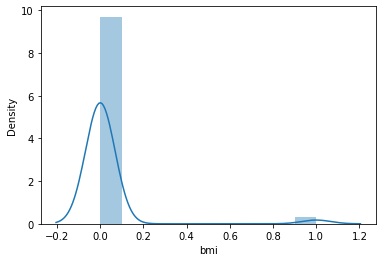

In [70]:
# Showing difference between y-test value and results from X_test
sns.distplot(y_test-qda_predict_test)

Text(0.5, 1.0, ' Actual Prices vs Predicted Prices')

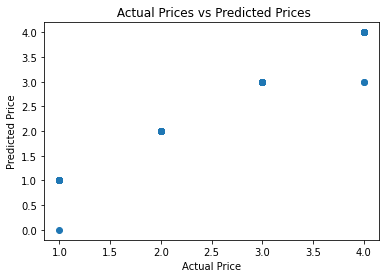

In [71]:
# Plot is linear so prediction is fairly accurate 
plt.scatter(y_test, qda_predict_test)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(" Actual Prices vs Predicted Prices")
# plt.show()

In [72]:
model.fit(X, y)

QuadraticDiscriminantAnalysis(reg_param=0.3)

In [73]:
# dump information to that file
pickle.dump(model, open('quadratic_discriminant_analysis.pkl', 'wb'))